# Preprocesado de las noticias

Pre-procesado para eliminar URLS, símbolos. Es decir, cosas que no son palabras

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import style

#One-hot encodding
from sklearn.preprocessing import LabelBinarizer

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
import swifter

#Nicer style
style.use('seaborn') 

In [2]:
import re #regexp

Tokenizer de NLTK (Natural Language Tool Kit) basado en expresiones regulares.

In [3]:
from nltk.tokenize import RegexpTokenizer

### Limpieza del dataset
Cargamos el dataset de noticias

/Users/air/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


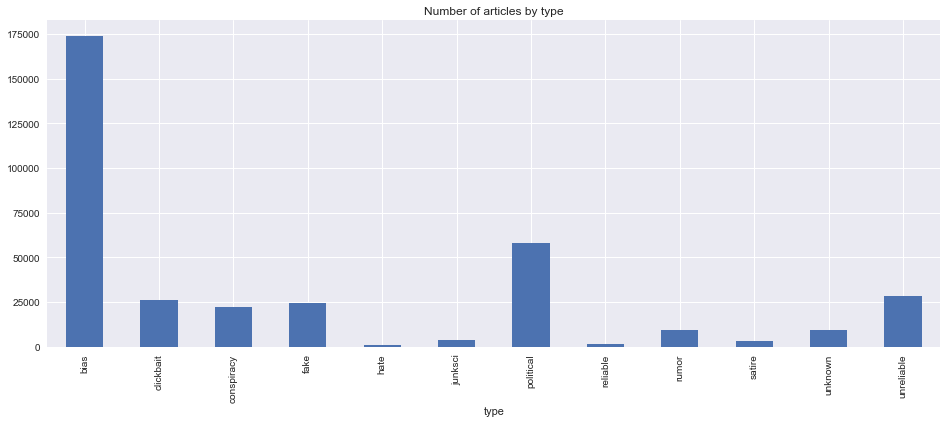

In [4]:
news = pd.read_csv("../data/news_sampled.csv", nrows=200_000)
news = news[news['type']!='bias']
news = news[news['type']!='clickbait']

#Load dataset for avoiding unbalance.
click_bias = pd.read_csv("../data/click_bias_only.csv", nrows=200_000)

news = pd.concat([news, click_bias])

del(click_bias)

fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

news = news[['type', 'content', 'title']]

#Remove columns with NaNs 
news = news.dropna()

Arreglamos el desbalanceo de bias del dataset.

In [5]:
news = pd.concat([news[news['type'] == 'bias'].head(60000).copy(), news[news['type'] != 'bias'].copy()])

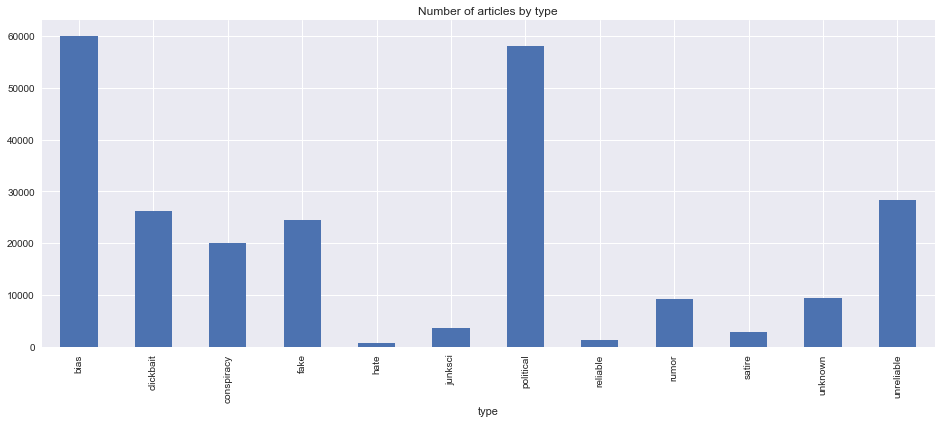

In [6]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

In [7]:
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

Limpiamos los campos que usaremos: Título y contenido

In [8]:
#Clean content
news['content'] = news.swifter.apply(lambda row: clean_text(row['content']), axis=1)
#Clean title
news['title'] = news.swifter.apply(lambda row: clean_text(row['title']), axis=1)

#Select only news with text
news = news[news['title'].str.len() >= 1]
news = news[news['content'].str.len() >= 1]

Pandas Apply: 100%|██████████| 244113/244113 [00:09<00:00, 26872.63it/s]


In [9]:
news.head(3)

,type,content,title
14,bias,"[Lila, Rose, president, of, the, pro, group, L...","[Biggest, pro, goal, Defunding, abortionists]"
15,bias,"[The, mobile, shortcut, will, then, be, added,...","[Discussion, Guidelines]"
16,bias,"[Two, black, leaders, who, were, prevented, fr...","[Protesters, against, genocide, of, abortion, ..."


Las noticias están organizadas en las siguientes categorías

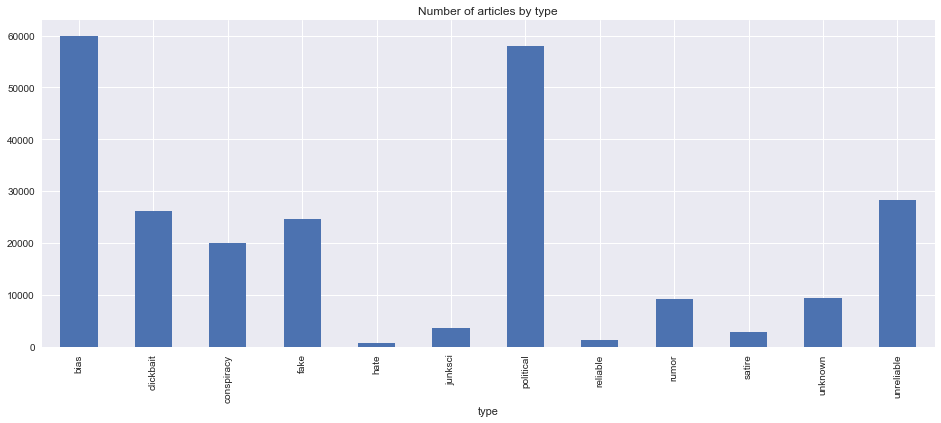

In [10]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

De aquí, y en base a las descripciones de [OpenSources](http://www.opensources.co) (de donde se han sacado las etiquetas del dataset) podemos agrupar varias categorías. Por ejemplo:
   * **Fake**
       * conspiracy
       * junksci
       * rumor
       * unknown
       * satire
       * hate
       * unreliable
       * fake
   * **Bias**
       * bias
   * **Truth**
       * reliable
       * political
   * **Clickbait**
       * clickbait

Convertimos los grupos en los nuevos.

In [11]:
def convert_tag(tag):
    """Convierte un tag a uno de tres grupos (fake, truth, clickbait)"""
    new_tag = None
    fake = set(['conspiracy', 'junksci', 'rumor', 'unknown', 'satire', 'hate', 'unreliable', 'fake'])
    truth = set(['reliable', 'political'])
    click = set(['clickbait'])
    bias = set(['bias'])
    
    if tag in fake:
        new_tag = 'fake'
    if tag in truth:
        new_tag = 'truth'
    if tag in click:
        new_tag = 'click'
    if tag in bias:
        new_tag = 'bias'
        
    return new_tag

In [12]:
news['type'] = news.swifter.apply(lambda row: convert_tag(row['type']), axis=1)

Pandas Apply: 100%|██████████| 243836/243836 [00:03<00:00, 70417.25it/s]


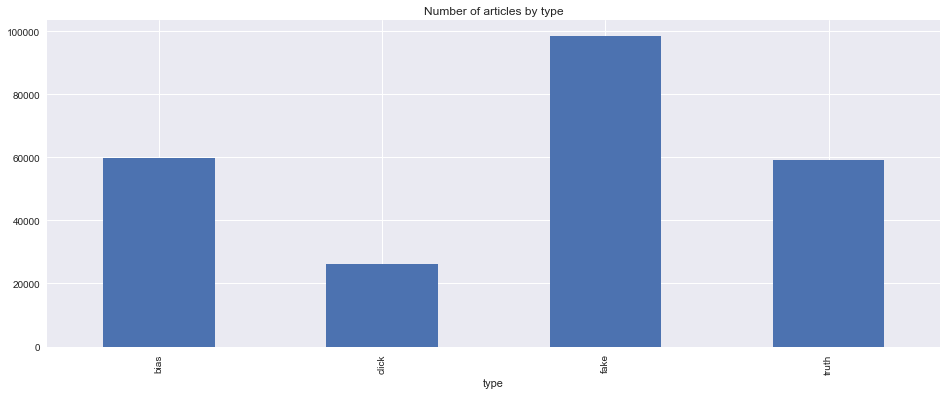

In [13]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

El dataset se encuentra bastante desbalanceado. Para poder entrenar correctamente las rededes neuronales se tienen que igualar más el número de samples por categoría.

En este caso, creamos una función para seleccionar los ejemplos que queramos para cada categoría. Las que están infrarrepresentadas se oversamplearán.

In [44]:
def equalize_categories(dataframe, categories):
    """
    This function takes a dataset and sets the number of samples of each
    class to the specified in the categories param
    :param dataframe (pandas DF)
    :param categories (dict) dictionary with the number of samples desired per class
    """
    #Copy dataframe structure
    df = dataframe.iloc[0:0]
    
    for cat in categories:
        selection = dataframe[dataframe['type'] == cat]
        count = selection['type'].count()
        if count >= categories[cat]:
            df = pd.concat([df, selection.head(categories[cat])])
        else:
            #Add n times the block
            block = dataframe.iloc[0:0]
            times = int(categories[cat] / count)    
            for i in range(times+1):
                block = pd.concat([block, selection])
            #Remove the remaining
            df = pd.concat([df, block.head(categories[cat])])
    
    return df

In [45]:
cats = {
    'bias': 50_000,
    'click': 50_000,
    'fake': 50_000,
    'truth': 50_000
}
equalized = equalize_categories(news, cats)

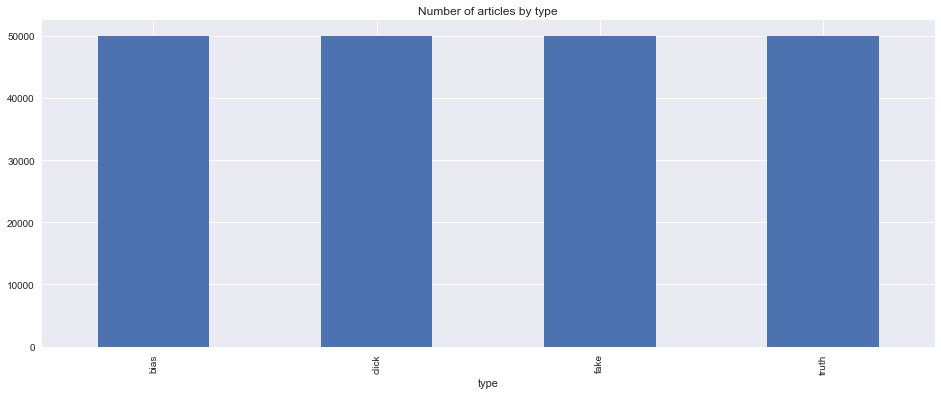

In [46]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
equalized.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

In [47]:
#del(news)
news = equalized.copy()
del(equalized)

### Word2Vec

In [48]:
from gensim.models import KeyedVectors

Cargamos los vectores de un modelo entrenado por Google con los textos de millones de noticias

In [49]:
model = KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin.gz", binary=True,
                                          limit=50000)

Un ejemplo de predicción de palabras similares a "Trump"

In [50]:
model.most_similar("Trump")

[('Donald_Trump', 0.8103920817375183),
 ('Apprentice', 0.47915542125701904),
 ('Paladino', 0.4655587077140808),
 ('Snooki', 0.4468839764595032),
 ('Harrah', 0.44451743364334106),
 ('MGM_Mirage', 0.44225355982780457),
 ('Vince_McMahon', 0.44097137451171875),
 ('Limbaugh', 0.4399239420890808),
 ('Palin', 0.43837088346481323),
 ('Giuliani', 0.4358449876308441)]

~~A continuación convertimos las palabras del título y contenido de las noticias en vectores numéricos para poder pasárselos a una red neuronal.~~

A continuación convertimos las palabras del título y contenido de las noticias a los índices del vocabulario de Word2Vec.

In [51]:
news['title'] = news.progress_apply(lambda r: 
                        [model.vocab[x].index for x in r['title'] if x in model.vocab], axis=1)

Pandas Apply: 100%|██████████| 200000/200000 [00:26<00:00, 7528.64it/s]


In [52]:
news['content'] = news.progress_apply(lambda r: 
                        [model.vocab[x].index for x in r['content'] if x in model.vocab], axis=1)

Pandas Apply: 100%|██████████| 200000/200000 [00:37<00:00, 5285.02it/s]


Eliminar los artículos que no tengan título (Word2Vec no tenía las palabras originales)

In [53]:
news = news[news['title'].map(len) >= 1]

In [54]:
#Reset index
news = news.reset_index().drop("index", axis=1)

Pero hay un **problema**: La entrada de la red no puede ser variable. Para solucionar esto, es necesario añadir padding a todos los arrays, de tal manera que todos tengan una longitud física.

Si miden menos de una cierta longitud $n$ ($l < n$) entonces se le añadirán "elementos" con ceros hasta alcanzar las dimensiones necesarias. Si mide más, se truncará de tal manera que $l = n$

In [55]:
def pad_array(array, token_len):
    diff_token = token_len - len(array)
    if(diff_token < 0):
        array = array[:token_len] #Truncate
    else:
        #Pad
        array += [0]*diff_token #Pad
        
    return array  

Es necesario encontrar un `token_len` que sea suficiente para que cubra, en general, la longitud de todos los artículos.

Pandas Apply: 100%|██████████| 192489/192489 [00:03<00:00, 50095.77it/s]


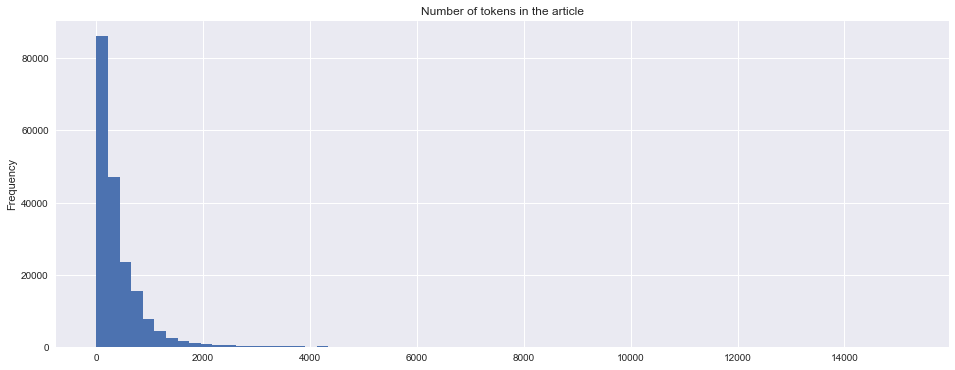

In [56]:
# Longitud en tokens de cada noticia
tokens_numbers = news.swifter.apply(lambda row: len(row['content']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 70, ax=ax)

In [57]:
print("Número medio de tokens por artículo: {}".format(int(np.mean(tokens_numbers))))
print("Desviación estándar de tokens por artículo: {}".format(int(np.std(tokens_numbers))))
print("Mediana de tokens por artículo: {}".format(int(np.median(tokens_numbers))))

Número medio de tokens por artículo: 408
Desviación estándar de tokens por artículo: 595
Mediana de tokens por artículo: 261


Escogemos el número máximo como $mean + 2\sigma$

In [58]:
max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Ventana de tokens escogida: {} - Cubre el {}% del dataset".format(max_tokens, percent_tokens*100))

Ventana de tokens escogida: 1598 - Cubre el 97.20555460312018% del dataset


In [59]:
n_tokens = max_tokens

In [60]:
news['content'] = news.apply(lambda r: pad_array(r['content'], n_tokens) , axis=1) #n_tokens

Lo mismo para los títulos

Número medio de tokens por título: 6
Desviación estándar de tokens por título: 3
Mediana de tokens por título: 6
Ventana de tokens escogida: 13 - Cubre el 96.92709713282316% del dataset


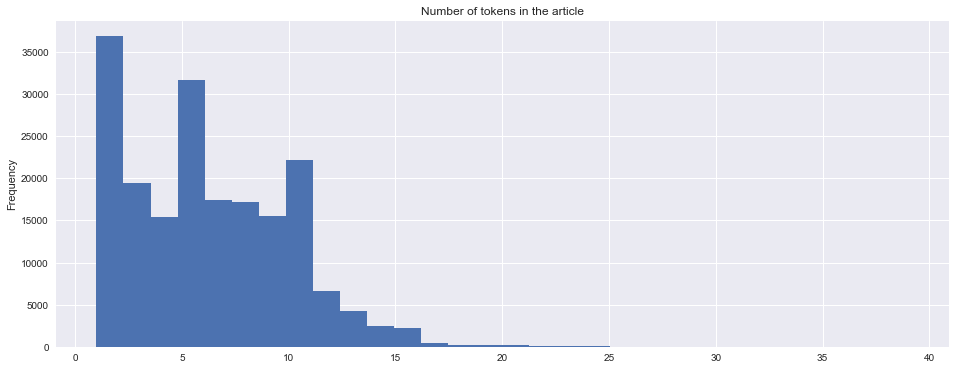

In [61]:
# Longitud en tokens de cada noticia
tokens_numbers = news.apply(lambda row: len(row['title']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 30, ax=ax)

print("Número medio de tokens por título: {}".format(int(np.mean(tokens_numbers))))
print("Desviación estándar de tokens por título: {}".format(int(np.std(tokens_numbers))))
print("Mediana de tokens por título: {}".format(int(np.median(tokens_numbers))))

max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

n_tokens = max_tokens

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Ventana de tokens escogida: {} - Cubre el {}% del dataset".format(max_tokens, percent_tokens*100))

In [62]:
news['title'] = news.progress_apply(lambda r: pad_array(r['title'], n_tokens) , axis=1)

Pandas Apply: 100%|██████████| 192489/192489 [00:03<00:00, 48581.60it/s]


### Convertir variable objetivo a OneHot Encodding

In [63]:
encoder = LabelBinarizer().fit(list(news['type']))
news['one_hot_label'] = news.apply(lambda r: encoder.transform([r['type']])[0], axis=1)

In [64]:
news.head()

,type,content,title,one_hot_label
0,bias,"[3958, 348, 11, 2261, 229, 4549, 5498, 115, 44...","[28009, 2261, 432, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0]"
1,bias,"[7, 1077, 34953, 23, 145, 16, 264, 14, 27, 737...","[27611, 24045, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0]"
2,bias,"[893, 987, 618, 31, 37, 5622, 17, 9425, 586, 1...","[15439, 103, 9090, 3993, 202, 288, 0, 0, 0, 0,...","[1, 0, 0, 0]"
3,bias,"[7, 1042, 17, 48, 43, 193, 28, 1446, 4, 3864, ...","[9274, 10600, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0]"
4,bias,"[73, 448, 344, 24, 1044, 402, 8586, 2014, 841,...","[2795, 14194, 31675, 6329, 1607, 10844, 5, 630...","[1, 0, 0, 0]"


Guardamos el dataset procesado como `.pickle` (serializado de objetos python).

In [65]:
news.to_pickle('../data/news_proc_12_3_19.pickle')

Guardamos el dataset procesado como `.csv`.

In [ ]:
news.to_csv('../data/news_proc_8_3_19.csv', sep=';')

In [ ]:
from ast import literal_eval


In [ ]:
news = pd.read_csv('../data/news_proc_8_3_19.csv', 
                       sep=';', converters={'content':literal_eval, 
                                       'title':literal_eval, 
                                       'one_hot_label':literal_eval})

In [ ]:
#PROBAR A CARGAR Y LUEGO HACER UN APPLY PARALELIZADOb

In [ ]:
news = pd.read_csv('../data/news_proc_8_3_19.csv', sep=';')

In [ ]:
news['title'] = news.swifter.apply(lambda r: literal_eval(r['title']), axis= 1)
news['content'] = news.swifter.apply(lambda r: literal_eval(r['content']), axis= 1)
news['one_hot_label'] = news.swifter.apply(lambda r: literal_eval(r['one_hot_label']), axis= 1)